In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Due to problems with the code, ChatGPT was used to help with the coding

In [3]:
def sampl_cond_distance(X, j):
    """
    X: data 
    j: index of the resampled row
    return: jth row is replaced in a copy of X
    """
    X_double = X.copy()

    # Split the data with/ without j
    X_j_wout = np.delete(X, j, axis=1)
    X_j = X[:, j]
    
    # Fit a linear model to predict X_j from the other columns
    model = LinearRegression().fit(X_j_wout, X_j) # noch zu ner logistic regression umbauen
    
    # Predict X_j values
    predicted_X_j = model.predict(X_j_wout)
    
    # Calculate residuals (actual - predicted)
    residuals = X_j - predicted_X_j
    
    # Sample from the residuals to preserve the distribution
    sampled_residuals = np.random.choice(residuals, size=len(residuals))
    
    # Generate new X_j values by adding sampled residuals to the predicted values
    new_X_j = predicted_X_j + sampled_residuals
    
    X_double[:, j] = new_X_j
    return X_double

In [4]:
def cond_rand_test(X:np.array, y:np.array, s:int, j:int): # maybe adding T:Callable again
    """
    X: samples
    y: responses
    K: number of permutations
    j: feature to analyze
    return: p-value for jth predictor
    """
    # the feature importance statistic
    help_feat = LogisticRegression().fit(X,y)
    coef = help_feat.coef_[0]

    imp_og = np.ones((s,)) * coef[j]
    imp_repl = np.ones((s,))


    for k in range(s):
        Xk = sampl_cond_distance(X, j)
        model = LogisticRegression().fit(Xk, y)
        coef = model.coef_[0]
        imp_repl[k] = coef[j]


    greater = imp_repl >= imp_og 
    pj = (1 / (s+1)) * (1+np.sum(greater))
    return pj

In [5]:
# Setting parameters
s = 1000  # Number of simulations
n = 500  # Number of samples
p = 200  # Number of predictors
ar_coef = 0.5  # Autoregressive coefficient
num_nonzero = 20  # Number of nonzero coefficients

This is the implementation of CRT. 

In [7]:
# Bernoulli with probability 0.5 determined by the logit transformation of a linear combination of X2 to X21

p_values_bl = np.zeros(s)

for i in range(s):
    np.random.seed(i)
    X = np.random.normal(size=(n, p))
    for j in range(1, p):
        X[:, j] += ar_coef * X[:, j - 1]

    nonzero_indices = np.random.choice(np.arange(1, p), size=num_nonzero, replace=False)
    # X2 +···+X21 doesn't imply the first 20 predictors rather a sequence of Xi, that's why random.choice can be used
    X_subset = X[:, nonzero_indices]
    logit_prob = 0.08 * np.sum(X_subset, axis=1)
    y = np.random.binomial(1, p=1 / (1 + np.exp(-logit_prob)), size=n)

    # p-values for β1 using cond_rand_test function
    p_values_bl[i] = cond_rand_test(X, y, s, j=1)  # index 0 corresponds to the intercept
    
# Plot histogram of p-values
plt.hist(p_values_bl, bins=20, color='blue', edgecolor='red')
plt.title('20 Nonzero Coefficients, AR(1) Design')
plt.xlabel('P-Values')
plt.ylabel('counts')
plt.xticks(np.linspace(0, 1, num=5), ['0.00', '0.25', '0.50', '0.75', '1.00'])
plt.grid(True, color='white', linestyle='-', alpha=1)
plt.grid(True, which='both', axis='x', color='white', linestyle='-', alpha=1)
plt.grid(True, which='both', axis='y', color='white', linestyle='-', alpha=1)
plt.gca().set_facecolor('lightgrey')
plt.gca().set_axisbelow(True)
plt.show()

In [ ]:
# p-value array
p_values_b = np.zeros(s)

# simulating data & fitting model for each simulation
for i in range(s):
    
    np.random.seed(i)
    # "i" as the seed (instead of fixed one) ensures that each simulation is INDEPENDENT(metrices assumption)
    X = np.random.normal(size=(n, p))
    for j in range(1, p):
        X[:, j] += ar_coef * X[:, j - 1]

    # variable Y
    y = np.random.binomial(1, p=0.5, size=n) # do not confuse the p here with the p in settings 

    # p-values for β1 using cond_rand_test function
    p_values_b[i] = cond_rand_test(X, y, s, j=1)  # index 0 corresponds to the intercept

# Peer review check
# Print p-values for examination
print("Generated p-values:", p_values_b)

# Plot histogram of p-values
plt.hist(p_values_b, bins=20, color='blue', edgecolor='red')
plt.title('20 Nonzero Coefficients, AR(1) Design')
plt.xlabel('P-Values')
plt.ylabel('counts')
plt.xticks(np.linspace(0, 1, num=5), ['0.00', '0.25', '0.50', '0.75', '1.00'])
plt.grid(True, color='white', linestyle='-', alpha=1)
plt.grid(True, which='both', axis='x', color='white', linestyle='-', alpha=1)
plt.grid(True, which='both', axis='y', color='white', linestyle='-', alpha=1)
plt.gca().set_facecolor('lightgrey')
plt.gca().set_axisbelow(True)
plt.show()

Simulation without the implementation of the CRT.

In [ ]:
# Bernoulli with probability 0.5

# p-value array
p_values_b = np.zeros(s)

# simulating data & fitting model for each simulation
for i in range(s):
    
    np.random.seed(i)
    # "i" as the seed (instead of fixed one) ensures that each simulation is INDEPENDENT(metrices assumption)
    X = np.random.normal(size=(n, p))
    for j in range(1, p):
        X[:, j] += ar_coef * X[:, j - 1]

    # variable Y
    y = np.random.binomial(1, p=0.5, size=n) # do not confuse the p here with the p in settings 

    # logit model
    X_const = sm.add_constant(X)
    logit_model = sm.Logit(y, X_const)
    logit_result = logit_model.fit()

    # p-values for β1
    p_values_b[i] = logit_result.pvalues[1] # index 0 corresponds to the intercept

In [3]:
# Bernoulli with probability 0.5

# p-value array
p_values_b = np.zeros(s)

# simulating data & fitting model for each simulation
for i in range(s):
    
    np.random.seed(i)
    # "i" as the seed (instead of fixed one) ensures that each simulation is INDEPENDENT(metrices assumption)
    X = np.random.normal(size=(n, p))
    for j in range(1, p):
        X[:, j] += ar_coef * X[:, j - 1]

    # variable Y
    y = np.random.binomial(1, p=0.5, size=n) # do not confuse the p here with the p in settings 

    # logit model
    X_const = sm.add_constant(X)
    logit_model = sm.Logit(y, X_const)
    logit_result = logit_model.fit()

    # p-values for β1
    p_values_b[i] = logit_result.pvalues[1] # index 0 corresponds to the intercept

Optimization terminated successfully.
         Current function value: 0.428342
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.435259
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399956
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412280
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407079
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.417158
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.402582
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.438191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432426
  

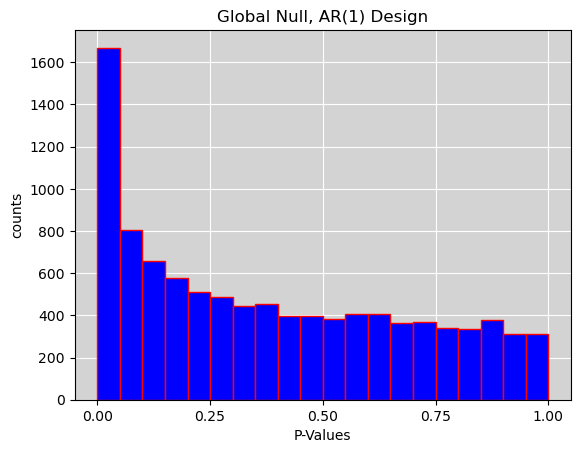

In [4]:
plt.hist(p_values_b, bins=20, color='blue', edgecolor='red')
plt.title('Global Null, AR(1) Design')
plt.xlabel('P-Values')
plt.ylabel('counts')
plt.xticks(np.linspace(0, 1, num=5), ['0.00', '0.25', '0.50', '0.75', '1.00'])
plt.grid(True, color='white', linestyle='-', alpha=1)
plt.grid(True, which='both', axis='x', color='white', linestyle='-', alpha=1)
plt.grid(True, which='both', axis='y', color='white', linestyle='-', alpha=1)
plt.gca().set_facecolor('lightgrey')
plt.gca().set_axisbelow(True)
plt.show()

In [5]:
# Bernoulli with probability 0.5 determined by the logit transformation of a linear combination of X2 to X21

num_nonzero = 20

p_values_bl = np.zeros(s)

for i in range(s):
    np.random.seed(i)
    X = np.random.normal(size=(n, p))
    for j in range(1, p):
        X[:, j] += ar_coef * X[:, j - 1]

    nonzero_indices = np.random.choice(np.arange(1, p), size=num_nonzero, replace=False)
    # X2 +···+X21 doesn't imply the first 20 predictors rather a sequence of Xi, that's why random.choice can be used
    X_subset = X[:, nonzero_indices]
    logit_prob = 0.08 * np.sum(X_subset, axis=1)
    y = np.random.binomial(1, p=1 / (1 + np.exp(-logit_prob)), size=n)

    X_const = sm.add_constant(X)
    logit_model = sm.Logit(y, X_const)
    logit_result = logit_model.fit()

    p_values_bl[i] = logit_result.pvalues[1]


Optimization terminated successfully.
         Current function value: 0.431177
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358799
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.380621
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.418471
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.378761
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.447951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362959
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.413463
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373027
  

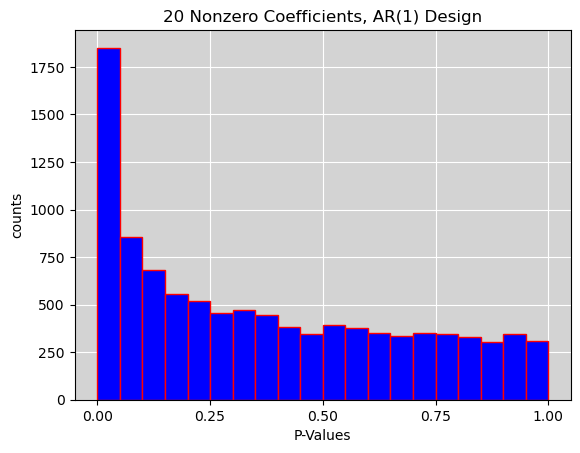

In [6]:
# Plot histogram of p-values
plt.hist(p_values_bl, bins=20, color='blue', edgecolor='red')
plt.title('20 Nonzero Coefficients, AR(1) Design')
plt.xlabel('P-Values')
plt.ylabel('counts')
plt.xticks(np.linspace(0, 1, num=5), ['0.00', '0.25', '0.50', '0.75', '1.00'])
plt.grid(True, color='white', linestyle='-', alpha=1)
plt.grid(True, which='both', axis='x', color='white', linestyle='-', alpha=1)
plt.grid(True, which='both', axis='y', color='white', linestyle='-', alpha=1)
plt.gca().set_facecolor('lightgrey')
plt.gca().set_axisbelow(True)
plt.show()